<a href="https://colab.research.google.com/github/akm2208/PCA-Analysis/blob/main/Impervious_Surface_Percentage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install geopandas rasterio rasterstats fiona shapely pyproj --quiet

Loaded 1620 tracts


,GEOID,percent_impervious
0,25009265102,None
1,25009268200,None
2,25009268400,None
3,25009250500,None
4,25027731300,None


IndexError: index 0 is out of bounds for axis 0 with size 0

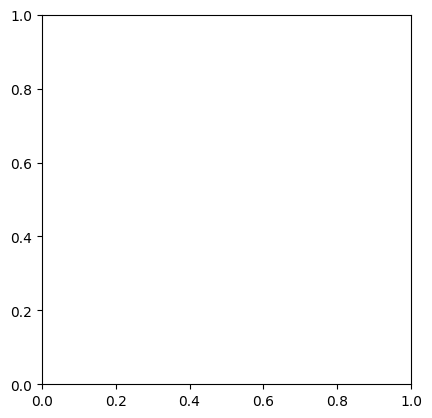

In [10]:
# --- Unzip shapefile ---
import zipfile, os
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Unzip the census tract shapefile
with zipfile.ZipFile("/content/tl_2020_25_tract.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/ma_tracts")

# --- Find .shp file inside /content/ma_tracts and its subdirectories ---
shp_path = None
for root, dirs, files in os.walk("/content/ma_tracts"):
    for file in files:
        if file.endswith(".shp"):
            shp_path = os.path.join(root, file)
            break
    if shp_path:
        break

if not shp_path:
    raise FileNotFoundError("No .shp file found in /content/ma_tracts")

tracts = gpd.read_file(shp_path)
print("Loaded", len(tracts), "tracts")

# --- Reproject to match raster CRS ---
raster_path = "/content/nlcd/NLCD_Z2rk0hkB4F1WgzVuUwQR/Annual_NLCD_FctImp_2023_CU_C1V0_Z2rk0hkB4F1WgzVuUwQR.tiff"
with rasterio.open(raster_path) as src:
    raster_crs = src.crs

tracts = tracts.to_crs(raster_crs)

# --- Compute zonal stats (mean impervious %) ---
stats = zonal_stats(tracts, raster_path, stats=["mean"], geojson_out=True)
results = [
    {"GEOID": f["properties"]["GEOID"], "percent_impervious": f["properties"]["mean"]}
    for f in stats
]

# --- Convert to DataFrame ---
import pandas as pd
df_impervious = pd.DataFrame(results)
df_impervious.dropna(inplace=True)
df_impervious["percent_impervious"] = df_impervious["percent_impervious"].round(2)

# --- Step 6: Convert zonal stats results into GeoDataFrame ---
from shapely.geometry import shape


In [12]:
import os
import geopandas as gpd
import rasterio

# --- Step 1: Define paths ---
raster_path = "/content/nlcd/NLCD_Z2rk0hkB4F1WgzVuUwQR/Annual_NLCD_FctImp_2023_CU_C1V0_Z2rk0hkB4F1WgzVuUwQR.tiff"

# --- Step 2: Recursively find the .shp file ---
shapefile_list = []
for root, dirs, files in os.walk("/content/ma_tracts"):
    for f in files:
        if f.endswith(".shp"):
            shapefile_list.append(os.path.join(root, f))

if not shapefile_list:
    raise FileNotFoundError("No shapefile found inside /content/ma_tracts")

shp_path = shapefile_list[0]
tracts = gpd.read_file(shp_path)
print("Loaded", len(tracts), "tracts")
print("Tracts CRS:", tracts.crs)

# --- Step 3: Open raster ---
with rasterio.open(raster_path) as src:
    print("Raster CRS:", src.crs)
    print("Raster bounds:", src.bounds)

# --- Step 4: Reproject tracts ---
tracts = tracts.to_crs(src.crs)
print("Reprojected Tracts bounds:", tracts.total_bounds)

Loaded 1620 tracts
Tracts CRS: EPSG:4269
Raster CRS: PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster bounds: BoundingBox(left=1830855.0, bottom=2297325.0, right=2143215.0, top=2479905.0)
Reprojected Tracts bounds: [1830830.45070964 2297324.6567469  2143235.14519698 2479926.4659298 ]


,GEOID,percent_impervious
0,25009265102,8.964473
1,25009268200,27.892654
2,25009268400,11.775402
3,25009250500,75.535503
4,25027731300,66.308153


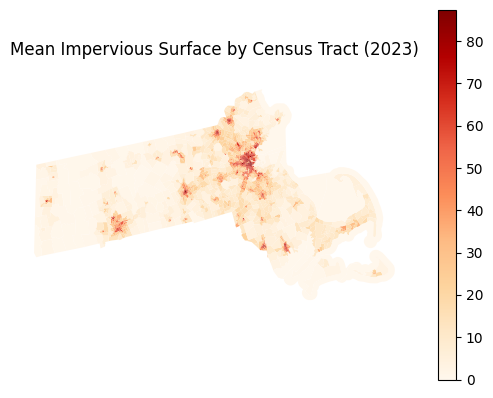

In [13]:
from rasterstats import zonal_stats
import pandas as pd
from shapely.geometry import shape
import geopandas as gpd

# --- Compute zonal statistics (mean impervious surface) ---
stats = zonal_stats(tracts, raster_path, stats=["mean"], geojson_out=True)

# --- Convert results into GeoDataFrame ---
results = []
for feature in stats:
    geoid = feature["properties"].get("GEOID", None)
    mean_val = feature["properties"].get("mean", None)
    geom = shape(feature["geometry"])
    results.append({
        "GEOID": geoid,
        "percent_impervious": mean_val,
        "geometry": geom
    })

gdf_result = gpd.GeoDataFrame(results, crs=tracts.crs)

# --- Display sample + plot ---
gdf_result = gdf_result.dropna(subset=["percent_impervious"])
display(gdf_result[["GEOID", "percent_impervious"]].head())

gdf_result.plot(column="percent_impervious", cmap="OrRd", legend=True)
plt.title("Mean Impervious Surface by Census Tract (2023)")
plt.axis("off")
plt.show()